In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=80f21021745e51aeff49574d4a32d2267e936d5dcb58fa0c91feeaec76a463b0
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
!pip install scikeras

In [4]:
!pip install tensorflow

# Import Necessary Libraries and Modules

In [5]:
# For data importation and preprocessing
import os # to fetch directory
import cv2  # to preprocess images
import imutils # to preprocess images
import pathlib # to handle files and directory
from PIL import Image, ImageEnhance # to preprocess and enhance images 
import numpy as np
import pandas as pd
import itertools

# For data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# For model implementation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.applications.resnet import ResNet50
import keras


# For miscellaneous
from tqdm import tqdm # to generate progress bar
import random # to randomize instances for images viewing

# For model evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Reading Datasets

In [6]:
# Initiate variables for training, testing and prediction directory
training_dir = "/kaggle/input/brain-tumor/brain tumor dl/Training/" # for training model purpose
validation_dir = "/kaggle/input/brain-tumor/brain tumor dl/Validation/" # for validation purpose in 
                                                                        # training image classification
testing_dir = "/kaggle/input/brain-tumor/brain tumor dl/Testing/" # for prediction purpose

In [7]:
# Walk through training directory and list number of files
for dirpath, dirnames, filenames in os.walk(training_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor/brain tumor dl/Training/'.
There are 0 directories and 1432 images in '/kaggle/input/brain-tumor/brain tumor dl/Training/pituitary'.
There are 0 directories and 1570 images in '/kaggle/input/brain-tumor/brain tumor dl/Training/notumor'.
There are 0 directories and 1314 images in '/kaggle/input/brain-tumor/brain tumor dl/Training/meningioma'.
There are 0 directories and 1296 images in '/kaggle/input/brain-tumor/brain tumor dl/Training/glioma'.


In [8]:
# Walk through validation directory and list number of files
for dirpath, dirnames, filenames in os.walk(validation_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor/brain tumor dl/Validation/'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor/brain tumor dl/Validation/pituitary'.
There are 0 directories and 405 images in '/kaggle/input/brain-tumor/brain tumor dl/Validation/notumor'.
There are 0 directories and 306 images in '/kaggle/input/brain-tumor/brain tumor dl/Validation/meningioma'.
There are 0 directories and 300 images in '/kaggle/input/brain-tumor/brain tumor dl/Validation/glioma'.


In [9]:
# Walk through prediction directory and list number of files
for dirpath, dirnames, filenames in os.walk(testing_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/kaggle/input/brain-tumor/brain tumor dl/Testing/'.
There are 0 directories and 25 images in '/kaggle/input/brain-tumor/brain tumor dl/Testing/pituitary'.
There are 0 directories and 25 images in '/kaggle/input/brain-tumor/brain tumor dl/Testing/notumor'.
There are 0 directories and 25 images in '/kaggle/input/brain-tumor/brain tumor dl/Testing/meningioma'.
There are 0 directories and 25 images in '/kaggle/input/brain-tumor/brain tumor dl/Testing/glioma'.


In [10]:
# Get the class names programmatically
data_dir = pathlib.Path(training_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # Create a list of class name from sub-directories
print(class_names)
print(f"The number of classes in training set are {len(class_names)}.")

['glioma' 'meningioma' 'notumor' 'pituitary']
The number of classes in training set are 4.


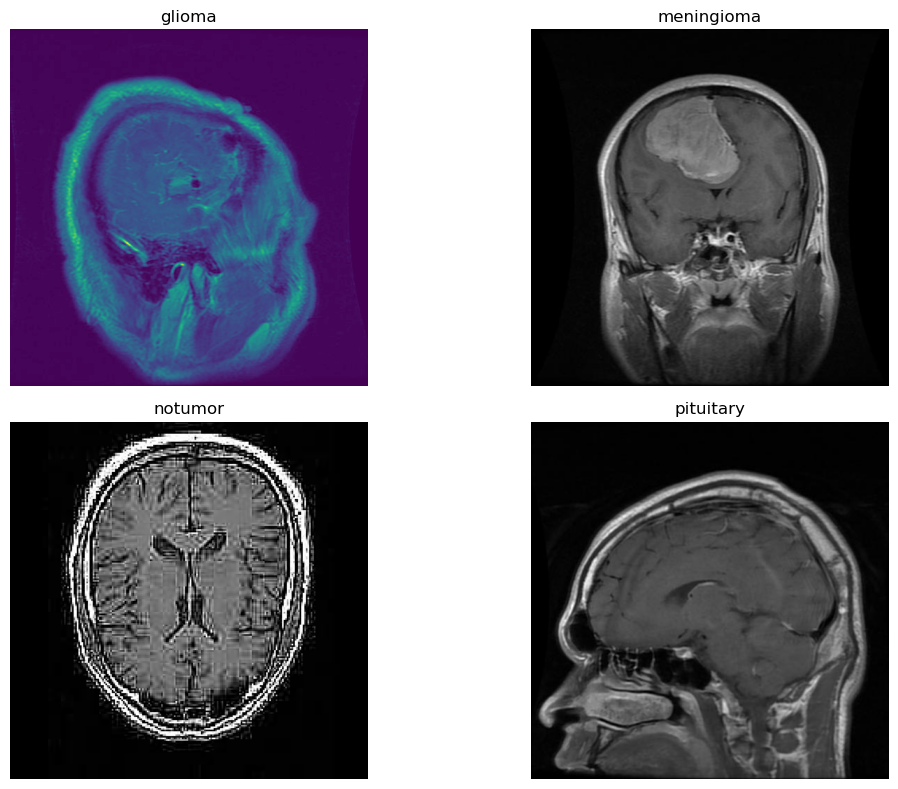

In [11]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(training_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

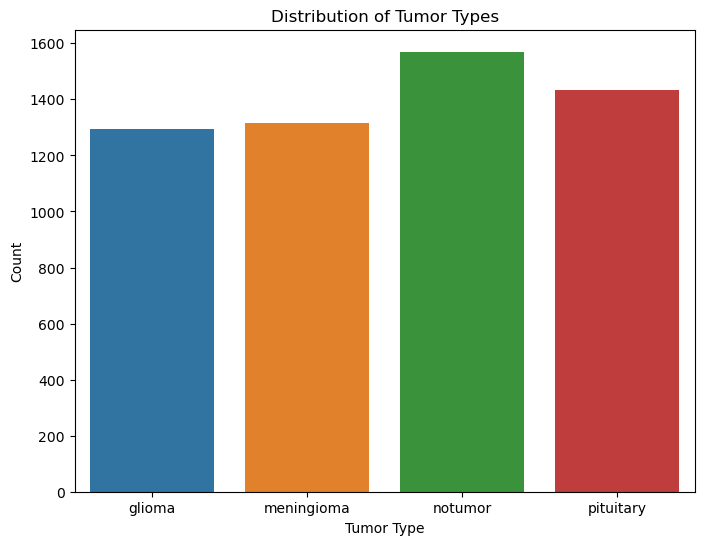

In [12]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(training_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

# Build Self-Defined Function
 * To enhance readability and reusability

In [13]:
# Plot the validation and training data separately

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [14]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [15]:
def create_modelcheckpoint(filepath):
    """
    Create model checkpoint by inputting filepath
    
    Args:
        filepath = path to save model in hdf5"""
    
    # Create model checkpoint
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = "val_accuracy",
                                                                 verbose = 1, save_best_only = True,
                                                                 mode = "auto", save_weights_only = False,
                                                                 save_format='h5')
    
    return model_checkpoint

In [16]:
def load_model_and_predict(model_filepath, test_datagen, y_test):
    """
    Load saved model in hdf5 format and predict on prediction set.
    Subsequently calculate metrics of the model
    
    Args:
    model_filepath = path to save model
    test_datagen = test generator from ImageDataGenerator
    y_test = true label of classes"""
    
    # Load model
    model = keras.models.load_model(model_filepath)
    # Predict on test_datagen
    predictions = model.predict(test_datagen)
    # Return the index of maximum value in an array and return it into array form
    predicted_categories = np.argmax(predictions, axis = 1)
    # Calculate results
    prediction_result = calculate_results(y_test, predicted_categories)
    
    return prediction_result

In [17]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

In [18]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Images Preprocessing

In [22]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 10

In [23]:
# Rescale training images and perform data augmentation for training set with rotation, 
# shift width and height, shear, zoom and flip the image horizontally and vertically
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Rescale validation images without perform additional data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Rescale testing images without perform additional data augmentatio
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5612 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [ ]:
# Retrieve a batch of augmented images and labels from the generator
images, labels = next(train_generator)

# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())

# Visualize the augmented images
num_classes = len(class_names)
num_images = len(images)
rows = int(np.ceil(num_images / num_classes))
fig, axes = plt.subplots(rows, num_classes, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        true_label = np.argmax(labels[i])
        ax.set_title(class_names[true_label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Output the cropped image into another directory with cropped/
if __name__ == "__main__":
    training = os.listdir(training_dir)
    validation = os.listdir(validation_dir)
    testing = os.listdir(testing_dir)
    
    for dir in training:
        save_path = 'cropped/Training/' + dir
        path = os.path.join(training_dir, dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))
            new_img = crop_img(image)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
            
    for dir in validation:
        save_path = 'cropped/Validation/' + dir
        path = os.path.join(validation_dir,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))
            new_img = crop_img(image)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
            
    for dir in testing:
        save_path = 'cropped/Testing/' + dir
        path = os.path.join(testing_dir,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))
            new_img = crop_img(image)
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)

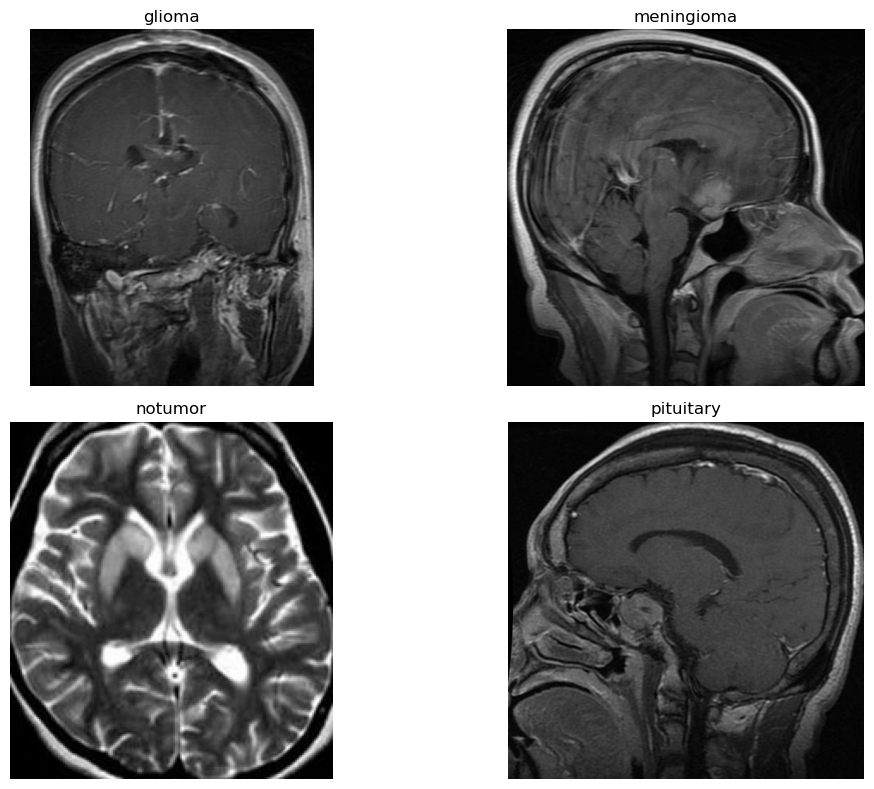

In [20]:
cropped_training_dir = "/kaggle/working/cropped/Training/"

# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(cropped_training_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [24]:
cropped_validation_dir = "/kaggle/working/cropped/Validation/"
cropped_testing_dir = "/kaggle/working/cropped/Testing/"

# Rescale cropped training images and perform data augmentation for training set with rotation, 
# shift width and height, shear, zoom and flip the image horizontally and vertically
cropped_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

cropped_train_generator = cropped_train_datagen.flow_from_directory(
    cropped_training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Rescale cropped validation images without perform additional data augmentation
cropped_valid_datagen = ImageDataGenerator(rescale=1./255)

cropped_valid_generator = cropped_valid_datagen.flow_from_directory(
    cropped_validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Rescale cropped testing images without perform additional data augmentatio
cropped_test_datagen = ImageDataGenerator(rescale=1./255)

cropped_test_generator = cropped_test_datagen.flow_from_directory(
    cropped_testing_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5612 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [21]:
X_train = [] # training images.
y_train  = [] # training labels.
X_valid = [] # validation images
y_valid = [] # validation labels
X_test = [] # testing images
y_test = [] # testing labels.

# Create a list of images with respective labels in each directory
for label in categories:
    # Training directory
    trainPath = os.path.join(training_dir,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        X_train.append(image)
        y_train.append(categories.index(label))        
    
    # Valiation directory
    validPath = os.path.join(validation_dir,label)
    for file in tqdm(os.listdir(validPath)):
        image = cv2.imread(os.path.join(validPath, file))
        X_valid.append(image)
        y_valid.append(categories.index(label))   
    
    # Testing directory
    # Create a list of true labels to compare with predicted labels as well
    testPath = os.path.join(testing_dir,label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        X_test.append(image)
        y_test.append(categories.index(label))

100%|██████████| 25/25 [00:00<00:00, 200.00it/s]


# Model Implementation and Validation

## Baseline Model 1

In [22]:
# Define the model architecture
baseline_model1 = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")
])

# Compile the model
baseline_model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
print("The model summary of baseline_model1 is: ")
baseline_model1.summary()

The model summary of baseline_model1 is: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)

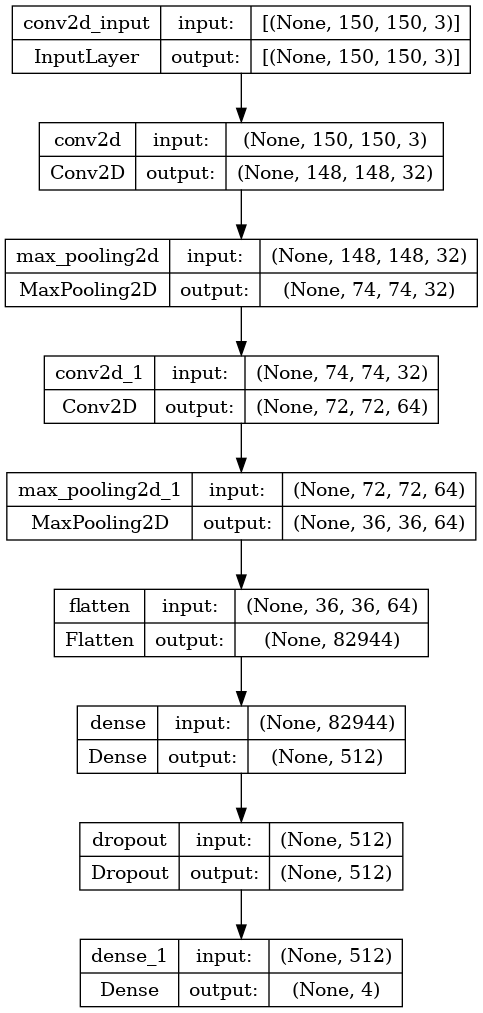

In [24]:
plot_model(baseline_model1, show_shapes = True, to_file = "baseline_model1.png")

In [26]:
# Set seed
tf.random.set_seed(42)

cp1 = create_modelcheckpoint("baseline_cp1.hdf5")

# Train the model
baseline_history = baseline_model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks = [cp1]
)

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.6149
Epoch 1: val_accuracy improved from -inf to 0.55703, saving model to baseline_cp1.hdf5
175/175 [==============================] - 58s 332ms/step - loss: 0.9125 - accuracy: 0.6149 - val_loss: 1.2312 - val_accuracy: 0.5570
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.6955
Epoch 2: val_accuracy improved from 0.55703 to 0.68984, saving model to baseline_cp1.hdf5
175/175 [==============================] - 50s 284ms/step - loss: 0.7595 - accuracy: 0.6955 - val_loss: 0.7695 - val_accuracy: 0.6898
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7396
Epoch 3: val_accuracy did not improve from 0.68984
175/175 [==============================] - 44s 249ms/step - loss: 0.6562 - accuracy: 0.7396 - val_loss: 0.8131 - val_accuracy: 0.6859
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss: 0.6203 - acc

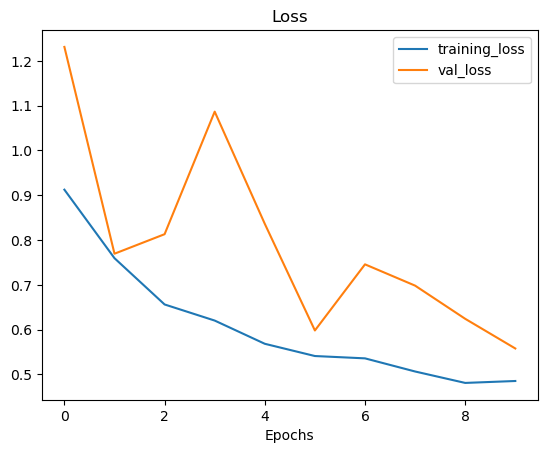

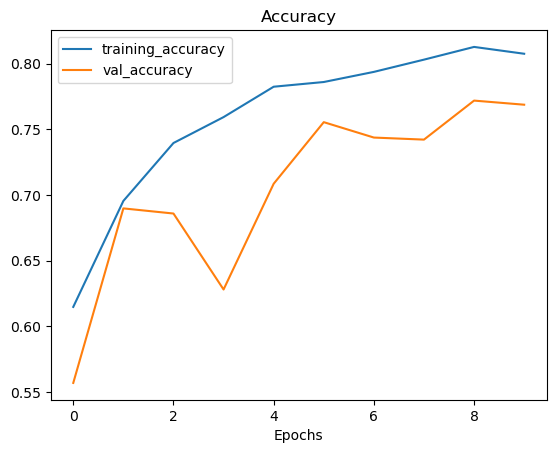

In [27]:
plot_loss_curves(baseline_history)

In [28]:
cnn_baseline1_result = load_model_and_predict("baseline_cp1.hdf5", test_generator, y_test)
print(cnn_baseline1_result)

4/4 [==============================] - 1s 147ms/step
{'accuracy': 77.0, 'precision': 0.7617916566192429, 'recall': 0.77, 'f1': 0.7475398265779392}


## Baseline model 2

In [29]:
# Define the model architecture
baseline_model2 = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")
])

# Compile the model
baseline_model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
print("The model summary of baseline_model2 is: ")
baseline_model2.summary()

The model summary of baseline_model2 is: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling

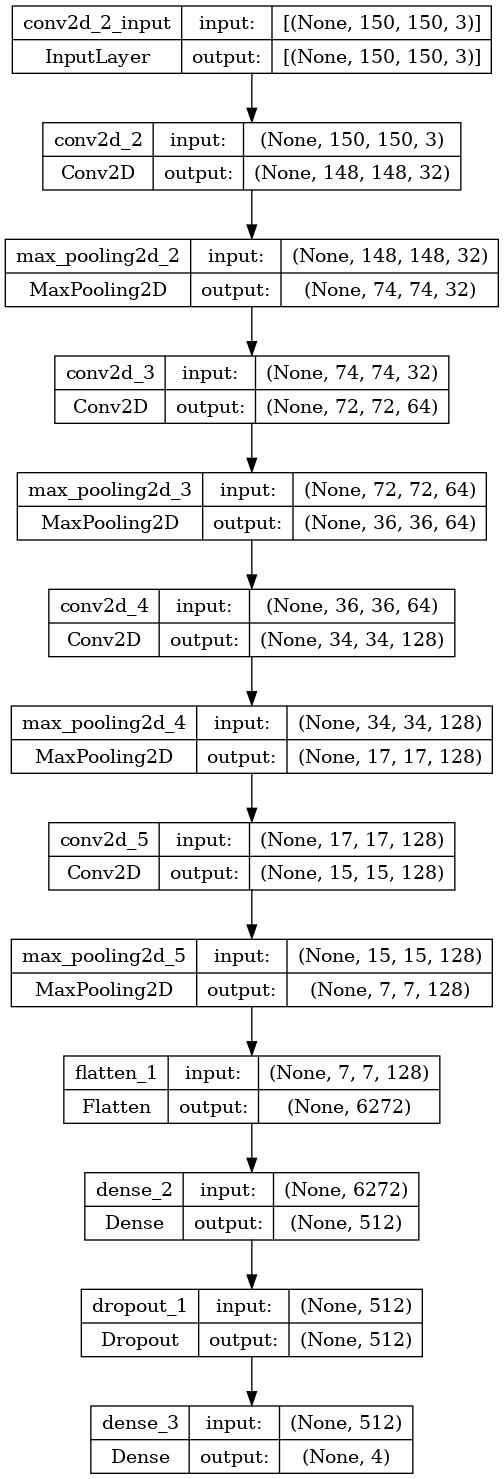

In [31]:
plot_model(baseline_model2, show_shapes = True, to_file = "baseline_model2.png")

In [32]:
# Set seed
tf.random.set_seed(42)

cp2 = create_modelcheckpoint("baseline_cp2.hdf5")

# Train the model
baseline_history2 = baseline_model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks = [cp2]
)

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.5701
Epoch 1: val_accuracy improved from -inf to 0.59766, saving model to baseline_cp2.hdf5
175/175 [==============================] - 51s 276ms/step - loss: 0.9844 - accuracy: 0.5701 - val_loss: 1.0103 - val_accuracy: 0.5977
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.6975
Epoch 2: val_accuracy did not improve from 0.59766
175/175 [==============================] - 48s 272ms/step - loss: 0.7497 - accuracy: 0.6975 - val_loss: 1.5687 - val_accuracy: 0.4914
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.6423 - accuracy: 0.7464
Epoch 3: val_accuracy improved from 0.59766 to 0.63359, saving model to baseline_cp2.hdf5
175/175 [==============================] - 47s 267ms/step - loss: 0.6423 - accuracy: 0.7464 - val_loss: 1.0075 - val_accuracy: 0.6336
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss: 0.5654 - acc

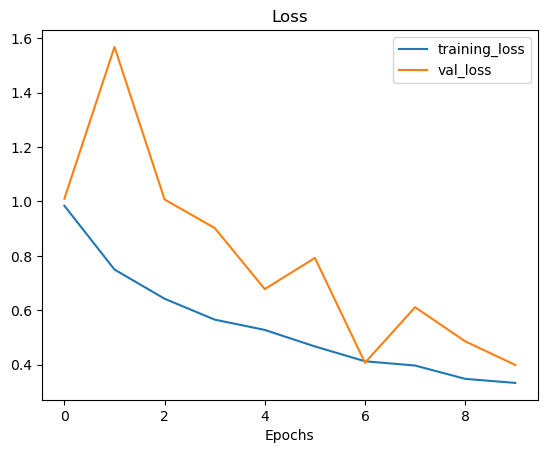

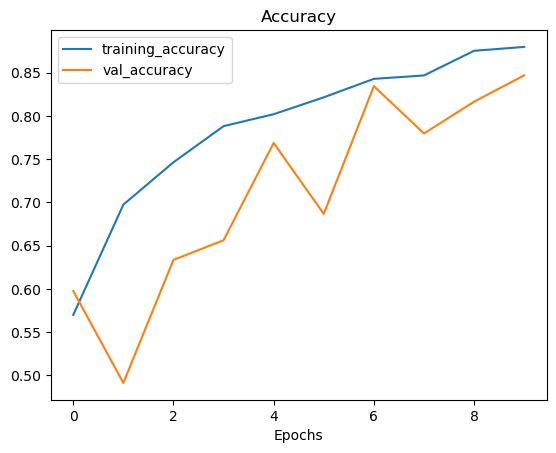

In [33]:
plot_loss_curves(baseline_history2)

In [34]:
cnn_baseline2_result = load_model_and_predict("baseline_cp2.hdf5", test_generator, y_test)
print(cnn_baseline2_result)

4/4 [==============================] - 0s 103ms/step
{'accuracy': 87.0, 'precision': 0.8910796957671958, 'recall': 0.87, 'f1': 0.8571505869172203}


## Baseline Model 2 

### Datasets with data augmentation and cropping

In [36]:
# Set seed
tf.random.set_seed(42)

cp3 = create_modelcheckpoint("cropped_baseline_cp.hdf5")

cropped_history = baseline_model2.fit(
    cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // batch_size,
    callbacks = [cp3])

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8140
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to cropped_baseline_cp.hdf5
175/175 [==============================] - 48s 271ms/step - loss: 0.4924 - accuracy: 0.8140 - val_loss: 0.6745 - val_accuracy: 0.7812
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.8550
Epoch 2: val_accuracy improved from 0.78125 to 0.88281, saving model to cropped_baseline_cp.hdf5
175/175 [==============================] - 41s 236ms/step - loss: 0.4000 - accuracy: 0.8550 - val_loss: 0.3436 - val_accuracy: 0.8828
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.8685
Epoch 3: val_accuracy did not improve from 0.88281
175/175 [==============================] - 40s 231ms/step - loss: 0.3545 - accuracy: 0.8685 - val_loss: 0.4082 - val_accuracy: 0.8641
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss

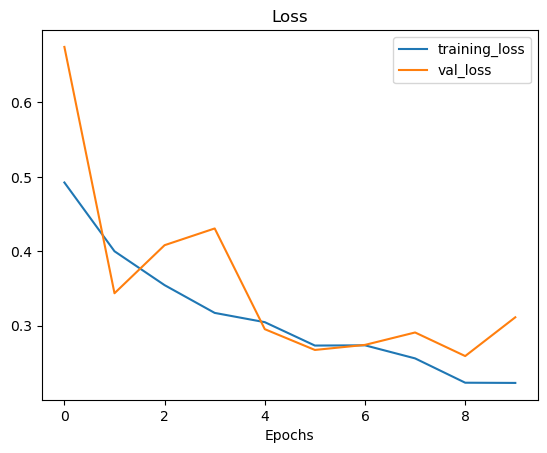

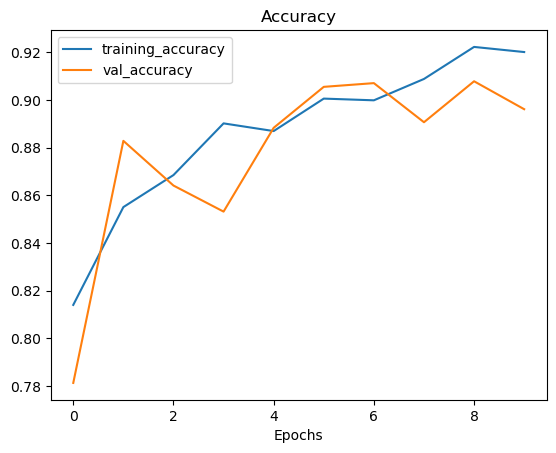

In [37]:
plot_loss_curves(cropped_history)

In [38]:
cr_cnn_baseline_result = load_model_and_predict("cropped_baseline_cp.hdf5", cropped_test_generator, y_test)
print(cr_cnn_baseline_result)

4/4 [==============================] - 0s 60ms/step
{'accuracy': 87.0, 'precision': 0.8696338383838383, 'recall': 0.87, 'f1': 0.8681819700056782}


## ResNet50

In [25]:
# Import resnet50
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, # Do not include the ImageNet classifier at the top.
     input_shape=(150, 150,3))

94765736/94765736 [==============================] - 2s 0us/step


In [40]:
# Create resnet model
resnet = net.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.5)(resnet)
resnet = Dense(4, activation="softmax")(resnet)
resnet = Model(inputs= net.input, outputs= resnet)

#compile our model.
resnet.compile(optimizer= "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

### Datasets with data augmentation (without cropping)

In [41]:
# Set seed
tf.random.set_seed(42)

cp4 = create_modelcheckpoint("resnet_cp.hdf5")

# Fit into datasets with data augmentation without cropping
resnet_history = resnet.fit(train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
                           callbacks = [cp4])

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.8054
Epoch 1: val_accuracy improved from -inf to 0.31641, saving model to resnet_cp.hdf5
175/175 [==============================] - 103s 343ms/step - loss: 0.5715 - accuracy: 0.8054 - val_loss: 1.9978 - val_accuracy: 0.3164
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8611
Epoch 2: val_accuracy did not improve from 0.31641
175/175 [==============================] - 56s 320ms/step - loss: 0.4155 - accuracy: 0.8611 - val_loss: 2.3152 - val_accuracy: 0.2102
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8957
Epoch 3: val_accuracy did not improve from 0.31641
175/175 [==============================] - 55s 315ms/step - loss: 0.3002 - accuracy: 0.8957 - val_loss: 1.7950 - val_accuracy: 0.2758
Epoch 4/10
175/175 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9163
Epoch 4: val_accuracy did n

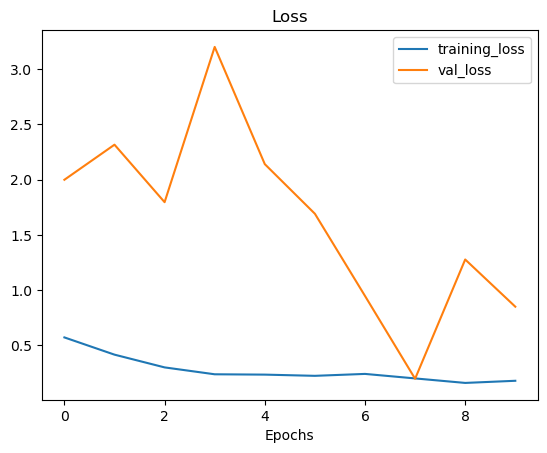

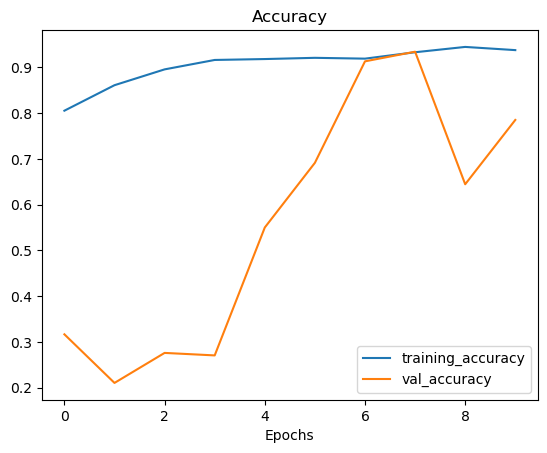

In [42]:
plot_loss_curves(resnet_history)

In [43]:
resnet_result = load_model_and_predict("resnet_cp.hdf5", cropped_test_generator, y_test)
print(resnet_result)

4/4 [==============================] - 2s 229ms/step
{'accuracy': 78.0, 'precision': 0.8023695054945056, 'recall': 0.78, 'f1': 0.7730786455595147}


### Datasets with data augmentation with cropping

In [44]:
# Set seed
tf.random.set_seed(42)

cp5 = create_modelcheckpoint("resnet2_cp.hdf5")

# Fit into datasets with data augmentation and cropping
resnet2_history = resnet.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // batch_size,
                           callbacks = [cp5])

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.9020
Epoch 1: val_accuracy improved from -inf to 0.31563, saving model to resnet2_cp.hdf5
175/175 [==============================] - 57s 311ms/step - loss: 0.3241 - accuracy: 0.9020 - val_loss: 1185.9248 - val_accuracy: 0.3156
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8939
Epoch 2: val_accuracy improved from 0.31563 to 0.31641, saving model to resnet2_cp.hdf5
175/175 [==============================] - 53s 299ms/step - loss: 0.3123 - accuracy: 0.8939 - val_loss: 200.7485 - val_accuracy: 0.3164
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.3424 - accuracy: 0.8993
Epoch 3: val_accuracy improved from 0.31641 to 0.69609, saving model to resnet2_cp.hdf5
175/175 [==============================] - 52s 294ms/step - loss: 0.3424 - accuracy: 0.8993 - val_loss: 11.8980 - val_accuracy: 0.6961
Epoch 4/10
175/175 [=======================

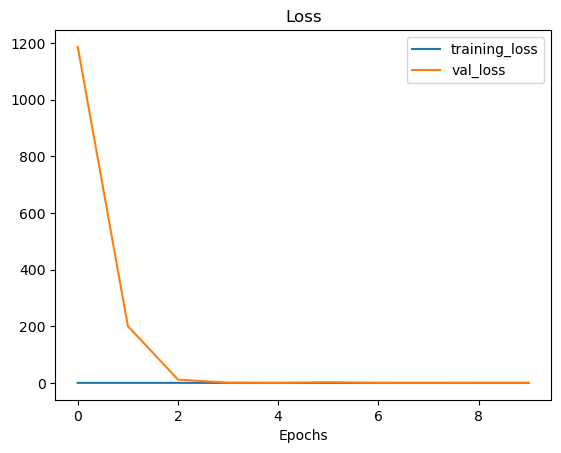

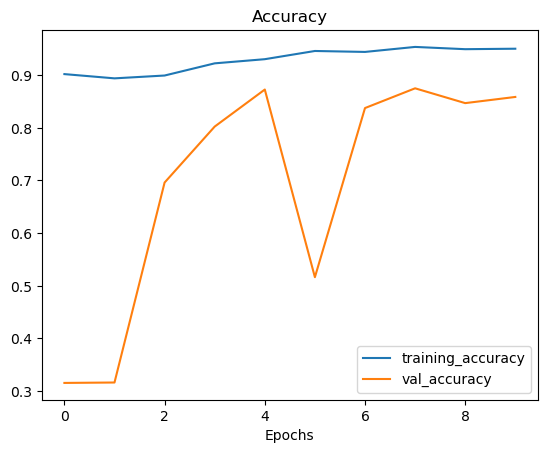

In [45]:
plot_loss_curves(resnet2_history)

In [47]:
resnet2_result = load_model_and_predict("resnet2_cp.hdf5", cropped_test_generator, y_test)
print(resnet_result)

4/4 [==============================] - 1s 74ms/step
{'accuracy': 78.0, 'precision': 0.8023695054945056, 'recall': 0.78, 'f1': 0.7730786455595147}


# Hyperparameter Tuning
## Generate data generator for hyperparameter tuning of batch size 16 and 8

In [33]:
cropped_train_generator_bs16 = cropped_train_datagen.flow_from_directory(
    cropped_training_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical"
)

cropped_valid_generator_bs16 = cropped_valid_datagen.flow_from_directory(
    cropped_validation_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical",
    shuffle=False
)

cropped_test_generator_bs16 = cropped_test_datagen.flow_from_directory(
    cropped_testing_dir,
    target_size=image_size,
    batch_size=16,
    class_mode="categorical",
    shuffle=False
)

Found 5612 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [32]:
cropped_train_generator_bs8 = cropped_train_datagen.flow_from_directory(
    cropped_training_dir,
    target_size=image_size,
    batch_size=8,
    class_mode="categorical"
)

cropped_valid_generator_bs8 = cropped_valid_datagen.flow_from_directory(
    cropped_validation_dir,
    target_size=image_size,
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)

cropped_test_generator_bs8 = cropped_test_datagen.flow_from_directory(
    cropped_testing_dir,
    target_size=image_size,
    batch_size=8,
    class_mode="categorical",
    shuffle=False
)

Found 5612 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


## CNN Baseline Model Hyperparameter Tuning

In [48]:
# Function to create model for KerasClassifier
def create_model(dropout_rate, learn_rate):
    # create model
    model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(dropout_rate),
    Dense(4, activation="softmax")
])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learn_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

### Epochs Tuning

In [49]:
tf.random.set_seed(42)

cnn_ht1 = create_model(0.5, 0.001)

cnn_ht_cp1 = create_modelcheckpoint("cnn_ht1.hdf5")

cnn_ht_history1 = cnn_ht1.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=20,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp1])

Epoch 1/20
175/175 [==============================] - ETA: 0s - loss: 1.0945 - accuracy: 0.4844
Epoch 1: val_accuracy improved from -inf to 0.47969, saving model to cnn_ht1.hdf5
175/175 [==============================] - 42s 228ms/step - loss: 1.0945 - accuracy: 0.4844 - val_loss: 1.6239 - val_accuracy: 0.4797
Epoch 2/20
175/175 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.6486
Epoch 2: val_accuracy did not improve from 0.47969
175/175 [==============================] - 38s 219ms/step - loss: 0.8538 - accuracy: 0.6486 - val_loss: 1.4788 - val_accuracy: 0.4563
Epoch 3/20
175/175 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.6935
Epoch 3: val_accuracy improved from 0.47969 to 0.55313, saving model to cnn_ht1.hdf5
175/175 [==============================] - 39s 221ms/step - loss: 0.7545 - accuracy: 0.6935 - val_loss: 1.2312 - val_accuracy: 0.5531
Epoch 4/20
175/175 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7

In [51]:
tf.random.set_seed(42)

cnn_ht2 = create_model(0.5, 0.001)

cnn_ht_cp2 = create_modelcheckpoint("cnn_ht2.hdf5")

cnn_ht_history2 = cnn_ht2.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp2])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.0751 - accuracy: 0.5034
Epoch 1: val_accuracy improved from -inf to 0.57578, saving model to cnn_ht2.hdf5
175/175 [==============================] - 41s 223ms/step - loss: 1.0751 - accuracy: 0.5034 - val_loss: 1.1343 - val_accuracy: 0.5758
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.6550
Epoch 2: val_accuracy did not improve from 0.57578
175/175 [==============================] - 40s 229ms/step - loss: 0.8388 - accuracy: 0.6550 - val_loss: 1.9465 - val_accuracy: 0.4266
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.7478 - accuracy: 0.6964
Epoch 3: val_accuracy improved from 0.57578 to 0.63516, saving model to cnn_ht2.hdf5
175/175 [==============================] - 40s 226ms/step - loss: 0.7478 - accuracy: 0.6964 - val_loss: 0.8947 - val_accuracy: 0.6352
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.7

In [50]:
cnn_ht_result1 = load_model_and_predict("cnn_ht1.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result1)

4/4 [==============================] - 0s 43ms/step
{'accuracy': 89.0, 'precision': 0.8956679894179893, 'recall': 0.89, 'f1': 0.8899341019931668}


In [52]:
cnn_ht_result2 = load_model_and_predict("cnn_ht2.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result2)

4/4 [==============================] - 0s 44ms/step
{'accuracy': 94.0, 'precision': 0.9418597706641185, 'recall': 0.94, 'f1': 0.9392804291527932}


### Learning rate Tuning

In [53]:
tf.random.set_seed(42)

cnn_ht3 = create_model(0.5, 0.01)

cnn_ht_cp3 = create_modelcheckpoint("cnn_ht3.hdf5")

cnn_ht_history3 = cnn_ht3.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp3])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.6405 - accuracy: 0.2810
Epoch 1: val_accuracy improved from -inf to 0.31641, saving model to cnn_ht3.hdf5
175/175 [==============================] - 43s 230ms/step - loss: 1.6405 - accuracy: 0.2810 - val_loss: 1.3803 - val_accuracy: 0.3164
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.2740
Epoch 2: val_accuracy did not improve from 0.31641
175/175 [==============================] - 41s 233ms/step - loss: 1.3844 - accuracy: 0.2740 - val_loss: 1.3803 - val_accuracy: 0.3164
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 1.3843 - accuracy: 0.2796
Epoch 3: val_accuracy did not improve from 0.31641
175/175 [==============================] - 40s 228ms/step - loss: 1.3843 - accuracy: 0.2796 - val_loss: 1.3805 - val_accuracy: 0.3164
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 1.3842 - accuracy: 0.2796
Epoch 4: val_accuracy did not 

In [55]:
tf.random.set_seed(42)

cnn_ht4 = create_model(0.5, 0.0001)

cnn_ht_cp4 = create_modelcheckpoint("cnn_ht4.hdf5")

cnn_ht_history4 = cnn_ht4.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp4])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.2514 - accuracy: 0.3726
Epoch 1: val_accuracy improved from -inf to 0.43906, saving model to cnn_ht4.hdf5
175/175 [==============================] - 43s 230ms/step - loss: 1.2514 - accuracy: 0.3726 - val_loss: 1.1621 - val_accuracy: 0.4391
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.5792
Epoch 2: val_accuracy improved from 0.43906 to 0.60000, saving model to cnn_ht4.hdf5
175/175 [==============================] - 41s 234ms/step - loss: 0.9751 - accuracy: 0.5792 - val_loss: 1.0179 - val_accuracy: 0.6000
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.6538
Epoch 3: val_accuracy did not improve from 0.60000
175/175 [==============================] - 40s 227ms/step - loss: 0.8407 - accuracy: 0.6538 - val_loss: 1.0490 - val_accuracy: 0.5953
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.6

In [54]:
cnn_ht_result3 = load_model_and_predict("cnn_ht3.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result3)

4/4 [==============================] - 0s 44ms/step
{'accuracy': 25.0, 'precision': 0.0625, 'recall': 0.25, 'f1': 0.1}


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
cnn_ht_result4 = load_model_and_predict("cnn_ht4.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result4)

4/4 [==============================] - 0s 44ms/step
{'accuracy': 83.0, 'precision': 0.8628287179236164, 'recall': 0.83, 'f1': 0.8295550489699426}


### Dropout Rate Tuning

In [57]:
tf.random.set_seed(42)

cnn_ht5 = create_model(0.3, 0.001)

cnn_ht_cp5 = create_modelcheckpoint("cnn_ht5.hdf5")

cnn_ht_history5 = cnn_ht5.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp5])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.0526 - accuracy: 0.5206
Epoch 1: val_accuracy improved from -inf to 0.48516, saving model to cnn_ht5.hdf5
175/175 [==============================] - 43s 230ms/step - loss: 1.0526 - accuracy: 0.5206 - val_loss: 1.3051 - val_accuracy: 0.4852
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.6409
Epoch 2: val_accuracy improved from 0.48516 to 0.57812, saving model to cnn_ht5.hdf5
175/175 [==============================] - 40s 230ms/step - loss: 0.8500 - accuracy: 0.6409 - val_loss: 1.0790 - val_accuracy: 0.5781
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7142
Epoch 3: val_accuracy improved from 0.57812 to 0.61406, saving model to cnn_ht5.hdf5
175/175 [==============================] - 40s 225ms/step - loss: 0.7094 - accuracy: 0.7142 - val_loss: 0.9941 - val_accuracy: 0.6141
Epoch 4/30
175/175 [==============================] - ETA:

In [58]:
tf.random.set_seed(42)

cnn_ht6 = create_model(0.4, 0.001)

cnn_ht_cp6 = create_modelcheckpoint("cnn_ht6.hdf5")

cnn_ht_history6 = cnn_ht6.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [cnn_ht_cp6])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.0859 - accuracy: 0.4855
Epoch 1: val_accuracy improved from -inf to 0.62734, saving model to cnn_ht6.hdf5
175/175 [==============================] - 40s 213ms/step - loss: 1.0859 - accuracy: 0.4855 - val_loss: 0.9833 - val_accuracy: 0.6273
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.6581
Epoch 2: val_accuracy did not improve from 0.62734
175/175 [==============================] - 38s 216ms/step - loss: 0.8273 - accuracy: 0.6581 - val_loss: 0.9601 - val_accuracy: 0.6062
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.7100
Epoch 3: val_accuracy improved from 0.62734 to 0.69531, saving model to cnn_ht6.hdf5
175/175 [==============================] - 38s 215ms/step - loss: 0.7273 - accuracy: 0.7100 - val_loss: 0.7207 - val_accuracy: 0.6953
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.7

In [59]:
cnn_ht_result5 = load_model_and_predict("cnn_ht5.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result5)

4/4 [==============================] - 0s 42ms/step
{'accuracy': 95.0, 'precision': 0.9519280538302277, 'recall': 0.95, 'f1': 0.9497096008214606}


In [60]:
cnn_ht_result6 = load_model_and_predict("cnn_ht6.hdf5", cropped_test_generator, y_test)
print(cnn_ht_result6)

4/4 [==============================] - 0s 39ms/step
{'accuracy': 98.0, 'precision': 0.9814814814814815, 'recall': 0.98, 'f1': 0.9801805337519623}


### Batch Size Tuning

In [62]:
tf.random.set_seed(42)

cnn_ht7 = create_model(0.4, 0.001)

cnn_ht_cp7 = create_modelcheckpoint("cnn_ht7.hdf5")

cnn_ht_history7 = cnn_ht7.fit(cropped_train_generator_bs16,
    steps_per_epoch=cropped_train_generator_bs16.samples // 16,
    epochs=30,
    validation_data=cropped_valid_generator_bs16,
    validation_steps=cropped_valid_generator_bs16.samples // 16,
                             callbacks = [cnn_ht_cp7])

Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.5084
Epoch 1: val_accuracy improved from -inf to 0.49614, saving model to cnn_ht7.hdf5
350/350 [==============================] - 41s 110ms/step - loss: 1.0664 - accuracy: 0.5084 - val_loss: 1.2602 - val_accuracy: 0.4961
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.8477 - accuracy: 0.6476
Epoch 2: val_accuracy improved from 0.49614 to 0.63426, saving model to cnn_ht7.hdf5
350/350 [==============================] - 38s 110ms/step - loss: 0.8477 - accuracy: 0.6476 - val_loss: 0.8979 - val_accuracy: 0.6343
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.7221
Epoch 3: val_accuracy improved from 0.63426 to 0.73302, saving model to cnn_ht7.hdf5
350/350 [==============================] - 38s 109ms/step - loss: 0.7069 - accuracy: 0.7221 - val_loss: 0.6614 - val_accuracy: 0.7330
Epoch 4/30
350/350 [==============================] - ETA:

In [67]:
tf.random.set_seed(42)

cnn_ht8 = create_model(0.4, 0.001)

cnn_ht_cp8 = create_modelcheckpoint("cnn_ht8.hdf5")

cnn_ht_history8 = cnn_ht8.fit(cropped_train_generator_bs8,
    steps_per_epoch=cropped_train_generator_bs8.samples // 8,
    epochs=30,
    validation_data=cropped_valid_generator_bs8,
    validation_steps=cropped_valid_generator_bs8.samples // 8,
                             callbacks = [cnn_ht_cp8])

Epoch 1/30
701/701 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.4982
Epoch 1: val_accuracy improved from -inf to 0.56595, saving model to cnn_ht8.hdf5
701/701 [==============================] - 42s 57ms/step - loss: 1.0794 - accuracy: 0.4982 - val_loss: 1.0800 - val_accuracy: 0.5660
Epoch 2/30
701/701 [==============================] - ETA: 0s - loss: 0.9166 - accuracy: 0.6062
Epoch 2: val_accuracy did not improve from 0.56595
701/701 [==============================] - 40s 57ms/step - loss: 0.9166 - accuracy: 0.6062 - val_loss: 1.1551 - val_accuracy: 0.5598
Epoch 3/30
701/701 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.6686
Epoch 3: val_accuracy improved from 0.56595 to 0.71396, saving model to cnn_ht8.hdf5
701/701 [==============================] - 40s 56ms/step - loss: 0.8138 - accuracy: 0.6686 - val_loss: 0.8515 - val_accuracy: 0.7140
Epoch 4/30
701/701 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.7325

In [63]:
cnn_ht_result7 = load_model_and_predict("cnn_ht7.hdf5", cropped_test_generator_bs16, y_test)
print(cnn_ht_result7)

7/7 [==============================] - 0s 25ms/step
{'accuracy': 96.0, 'precision': 0.9626068376068377, 'recall': 0.96, 'f1': 0.9599098231764063}


In [68]:
cnn_ht_result8 = load_model_and_predict("cnn_ht8.hdf5", cropped_test_generator_bs8, y_test)
print(cnn_ht_result8)

13/13 [==============================] - 0s 14ms/step
{'accuracy': 94.0, 'precision': 0.9407051282051282, 'recall': 0.94, 'f1': 0.9399759903961583}


### Loss and Accuracy Curve for baseline-CNN model 2 with best hyperparameters

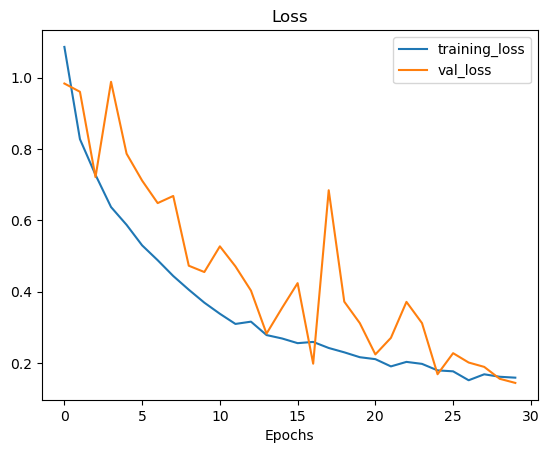

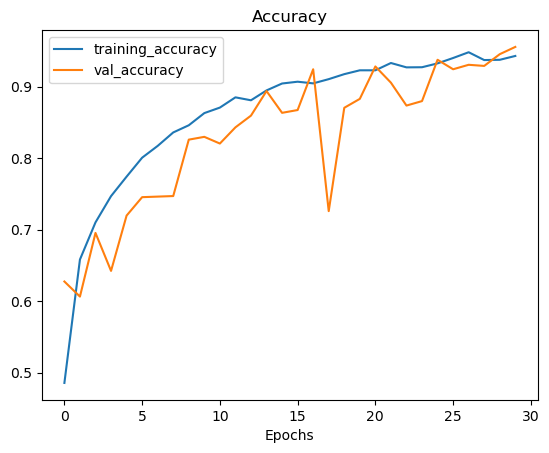

In [69]:
plot_loss_curves(cnn_ht_history6)

## ResNet50

In [26]:
# Define a resnet model with dropout_rate and learning_rate arguments
def create_resnet(dropout_rate, learn_rate):

    resnet = net.output
    resnet = GlobalAveragePooling2D()(resnet)
    resnet = Dropout(dropout_rate)(resnet)
    resnet = Dense(4, activation="softmax")(resnet)
    resnet = Model(inputs= net.input, outputs= resnet)

    #compile our model.
    resnet.compile(optimizer= tf.keras.optimizers.Adam(learn_rate), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return resnet

### Epochs Tuning

In [27]:
tf.random.set_seed(42)

res_ht1 = create_resnet(0.5, 0.001)

res_ht_cp1 = create_modelcheckpoint("res_ht1.hdf5")

res_ht_history1 = res_ht1.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=20,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp1])

Epoch 1/20
175/175 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.8263
Epoch 1: val_accuracy improved from -inf to 0.23438, saving model to res_ht1.hdf5
175/175 [==============================] - 106s 320ms/step - loss: 0.5816 - accuracy: 0.8263 - val_loss: 2.4161 - val_accuracy: 0.2344
Epoch 2/20
175/175 [==============================] - ETA: 0s - loss: 0.3045 - accuracy: 0.8970
Epoch 2: val_accuracy did not improve from 0.23438
175/175 [==============================] - 52s 294ms/step - loss: 0.3045 - accuracy: 0.8970 - val_loss: 1.6036 - val_accuracy: 0.2344
Epoch 3/20
175/175 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8762
Epoch 3: val_accuracy improved from 0.23438 to 0.30391, saving model to res_ht1.hdf5
175/175 [==============================] - 50s 283ms/step - loss: 0.3853 - accuracy: 0.8762 - val_loss: 2.7839 - val_accuracy: 0.3039
Epoch 4/20
175/175 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.

In [29]:
tf.random.set_seed(42)

res_ht2 = create_resnet(0.5, 0.001)

res_ht_cp2 = create_modelcheckpoint("res_ht2.hdf5")

res_ht_history2 = res_ht2.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp2])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9246
Epoch 1: val_accuracy improved from -inf to 0.77812, saving model to res_ht2.hdf5
175/175 [==============================] - 89s 300ms/step - loss: 0.2405 - accuracy: 0.9246 - val_loss: 3.0537 - val_accuracy: 0.7781
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9407
Epoch 2: val_accuracy improved from 0.77812 to 0.83984, saving model to res_ht2.hdf5
175/175 [==============================] - 51s 293ms/step - loss: 0.1738 - accuracy: 0.9407 - val_loss: 0.5684 - val_accuracy: 0.8398
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9470
Epoch 3: val_accuracy did not improve from 0.83984
175/175 [==============================] - 50s 286ms/step - loss: 0.1600 - accuracy: 0.9470 - val_loss: 1.2960 - val_accuracy: 0.7805
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9

In [32]:
res_ht_result1 = load_model_and_predict("res_ht1.hdf5", cropped_test_generator, y_test)
print(res_ht_result1)

4/4 [==============================] - 1s 72ms/step
{'accuracy': 97.0, 'precision': 0.9732142857142857, 'recall': 0.97, 'f1': 0.9703303491207804}


In [33]:
res_ht_result2 = load_model_and_predict("res_ht2.hdf5", cropped_test_generator, y_test)
print(res_ht_result2)

4/4 [==============================] - 1s 74ms/step
{'accuracy': 99.0, 'precision': 0.9903846153846154, 'recall': 0.99, 'f1': 0.9899959983993597}


### Learning Rate Tuning

In [35]:
tf.random.set_seed(42)

res_ht3 = create_resnet(0.5, 0.01)

res_ht_cp3 = create_modelcheckpoint("res_ht3.hdf5")

res_ht_history3 = res_ht3.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp3])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.1044 - accuracy: 0.6289
Epoch 1: val_accuracy improved from -inf to 0.31641, saving model to res_ht3.hdf5
175/175 [==============================] - 91s 300ms/step - loss: 1.1044 - accuracy: 0.6289 - val_loss: 5309.8730 - val_accuracy: 0.3164
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 1.1350 - accuracy: 0.6186
Epoch 2: val_accuracy did not improve from 0.31641
175/175 [==============================] - 49s 277ms/step - loss: 1.1350 - accuracy: 0.6186 - val_loss: 2456.8687 - val_accuracy: 0.3164
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 1.0031 - accuracy: 0.7029
Epoch 3: val_accuracy improved from 0.31641 to 0.31797, saving model to res_ht3.hdf5
175/175 [==============================] - 53s 301ms/step - loss: 1.0031 - accuracy: 0.7029 - val_loss: 425.5934 - val_accuracy: 0.3180
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 1.2555 - accur

In [38]:
tf.random.set_seed(42)

res_ht4 = create_resnet(0.5, 0.0001)

res_ht_cp4 = create_modelcheckpoint("res_ht4.hdf5")

res_ht_history4 = res_ht4.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp4])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.2638 - accuracy: 0.6063
Epoch 1: val_accuracy improved from -inf to 0.74453, saving model to res_ht4.hdf5
175/175 [==============================] - 88s 289ms/step - loss: 1.2638 - accuracy: 0.6063 - val_loss: 1.1386 - val_accuracy: 0.7445
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.7792
Epoch 2: val_accuracy improved from 0.74453 to 0.74609, saving model to res_ht4.hdf5
175/175 [==============================] - 49s 278ms/step - loss: 1.0270 - accuracy: 0.7792 - val_loss: 0.9156 - val_accuracy: 0.7461
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.7928
Epoch 3: val_accuracy improved from 0.74609 to 0.75625, saving model to res_ht4.hdf5
175/175 [==============================] - 49s 280ms/step - loss: 0.8187 - accuracy: 0.7928 - val_loss: 0.7753 - val_accuracy: 0.7563
Epoch 4/30
175/175 [==============================] - ETA:

In [37]:
res_ht_result3 = load_model_and_predict("res_ht3.hdf5", cropped_test_generator, y_test)
print(res_ht_result3)

4/4 [==============================] - 1s 74ms/step
{'accuracy': 80.0, 'precision': 0.8086366758241758, 'recall': 0.8, 'f1': 0.7869438815171625}


In [40]:
res_ht_result4 = load_model_and_predict("res_ht4.hdf5", cropped_test_generator, y_test)
print(res_ht_result4)

4/4 [==============================] - 1s 70ms/step
{'accuracy': 88.0, 'precision': 0.8875851617256543, 'recall': 0.88, 'f1': 0.8774555276656117}


### Dropout Rate Tuning

In [41]:
tf.random.set_seed(42)

res_ht5 = create_resnet(0.3, 0.001)

res_ht_cp5 = create_modelcheckpoint("res_ht5.hdf5")

res_ht_history5 = res_ht5.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp5])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.8443
Epoch 1: val_accuracy improved from -inf to 0.83047, saving model to res_ht5.hdf5
175/175 [==============================] - 90s 304ms/step - loss: 0.4899 - accuracy: 0.8443 - val_loss: 0.4873 - val_accuracy: 0.8305
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8801
Epoch 2: val_accuracy did not improve from 0.83047
175/175 [==============================] - 51s 289ms/step - loss: 0.3257 - accuracy: 0.8801 - val_loss: 0.5949 - val_accuracy: 0.7969
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8849
Epoch 3: val_accuracy improved from 0.83047 to 0.85547, saving model to res_ht5.hdf5
175/175 [==============================] - 49s 281ms/step - loss: 0.3088 - accuracy: 0.8849 - val_loss: 0.3629 - val_accuracy: 0.8555
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8

In [45]:
tf.random.set_seed(42)

res_ht6 = create_resnet(0.4, 0.001)

res_ht_cp6 = create_modelcheckpoint("res_ht6.hdf5")

res_ht_history6 = res_ht6.fit(cropped_train_generator,
    steps_per_epoch=cropped_train_generator.samples // 32,
    epochs=30,
    validation_data=cropped_valid_generator,
    validation_steps=cropped_valid_generator.samples // 32,
                             callbacks = [res_ht_cp6])

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.9075
Epoch 1: val_accuracy improved from -inf to 0.91172, saving model to res_ht6.hdf5
175/175 [==============================] - 91s 307ms/step - loss: 0.3125 - accuracy: 0.9075 - val_loss: 0.2359 - val_accuracy: 0.9117
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9403
Epoch 2: val_accuracy did not improve from 0.91172
175/175 [==============================] - 50s 285ms/step - loss: 0.1679 - accuracy: 0.9403 - val_loss: 0.2907 - val_accuracy: 0.8930
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9462
Epoch 3: val_accuracy improved from 0.91172 to 0.93594, saving model to res_ht6.hdf5
175/175 [==============================] - 52s 294ms/step - loss: 0.1593 - accuracy: 0.9462 - val_loss: 0.1831 - val_accuracy: 0.9359
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.9

In [44]:
res_ht_result5 = load_model_and_predict("res_ht5.hdf5", cropped_test_generator, y_test)
print(res_ht_result5)

4/4 [==============================] - 1s 73ms/step
{'accuracy': 96.0, 'precision': 0.9655172413793103, 'recall': 0.96, 'f1': 0.9604219938566443}


In [47]:
res_ht_result6 = load_model_and_predict("res_ht6.hdf5", cropped_test_generator, y_test)
print(res_ht_result6)

4/4 [==============================] - 1s 75ms/step
{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


### Batch Size Tuning

In [34]:
tf.random.set_seed(42)

res_ht7 = create_resnet(0.4, 0.001)

res_ht_cp7 = create_modelcheckpoint("res_ht7.hdf5")

res_ht_history7 = res_ht7.fit(cropped_train_generator_bs16,
    steps_per_epoch=cropped_train_generator_bs16.samples // 16,
    epochs=30,
    validation_data=cropped_valid_generator_bs16,
    validation_steps=cropped_valid_generator_bs16.samples // 16,
                             callbacks = [res_ht_cp7])

Epoch 1/30
350/350 [==============================] - ETA: 0s - loss: 0.7922 - accuracy: 0.7443
Epoch 1: val_accuracy improved from -inf to 0.23148, saving model to res_ht7.hdf5
350/350 [==============================] - 115s 188ms/step - loss: 0.7922 - accuracy: 0.7443 - val_loss: 2.4983 - val_accuracy: 0.2315
Epoch 2/30
350/350 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8501
Epoch 2: val_accuracy improved from 0.23148 to 0.29012, saving model to res_ht7.hdf5
350/350 [==============================] - 60s 171ms/step - loss: 0.4394 - accuracy: 0.8501 - val_loss: 4.2449 - val_accuracy: 0.2901
Epoch 3/30
350/350 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8822
Epoch 3: val_accuracy improved from 0.29012 to 0.43210, saving model to res_ht7.hdf5
350/350 [==============================] - 60s 171ms/step - loss: 0.3474 - accuracy: 0.8822 - val_loss: 2.5224 - val_accuracy: 0.4321
Epoch 4/30
350/350 [==============================] - ETA

In [37]:
tf.random.set_seed(42)

res_ht8 = create_resnet(0.4, 0.001)

res_ht_cp8 = create_modelcheckpoint("res_ht8.hdf5")

res_ht_history8 = res_ht8.fit(cropped_train_generator_bs8,
    steps_per_epoch=cropped_train_generator_bs8.samples // 8,
    epochs=30,
    validation_data=cropped_valid_generator_bs8,
    validation_steps=cropped_valid_generator_bs8.samples // 8,
                             callbacks = [res_ht_cp8])

Epoch 1/30
701/701 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9258
Epoch 1: val_accuracy improved from -inf to 0.67255, saving model to res_ht8.hdf5
701/701 [==============================] - 118s 101ms/step - loss: 0.2143 - accuracy: 0.9258 - val_loss: 0.9542 - val_accuracy: 0.6725
Epoch 2/30
701/701 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9333
Epoch 2: val_accuracy did not improve from 0.67255
701/701 [==============================] - 68s 96ms/step - loss: 0.1996 - accuracy: 0.9333 - val_loss: 2.4642 - val_accuracy: 0.4617
Epoch 3/30
701/701 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9329
Epoch 3: val_accuracy improved from 0.67255 to 0.89494, saving model to res_ht8.hdf5
701/701 [==============================] - 69s 99ms/step - loss: 0.1999 - accuracy: 0.9329 - val_loss: 0.3171 - val_accuracy: 0.8949
Epoch 4/30
701/701 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.93

In [41]:
res_ht_result7 = load_model_and_predict("res_ht7.hdf5", cropped_test_generator_bs16, y_test)
print(res_ht_result7)

7/7 [==============================] - 1s 42ms/step
{'accuracy': 93.0, 'precision': 0.9358211233211233, 'recall': 0.93, 'f1': 0.9276254174977815}


In [40]:
res_ht_result8 = load_model_and_predict("res_ht8.hdf5", cropped_test_generator_bs8, y_test)
print(res_ht_result8)

13/13 [==============================] - 1s 28ms/step
{'accuracy': 99.0, 'precision': 0.9903846153846154, 'recall': 0.99, 'f1': 0.9899959983993597}


### Loss and Accuracy Curve for ResNet50 with best hyperparameter

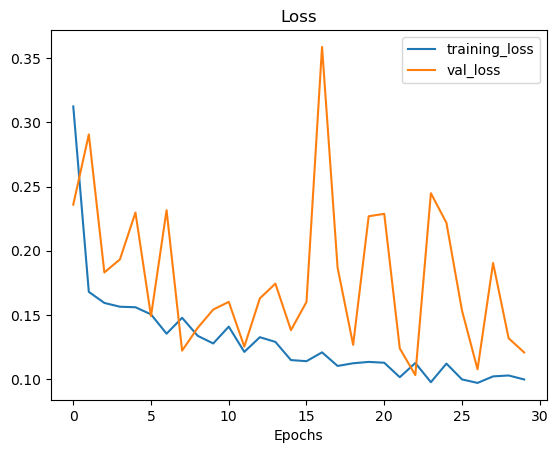

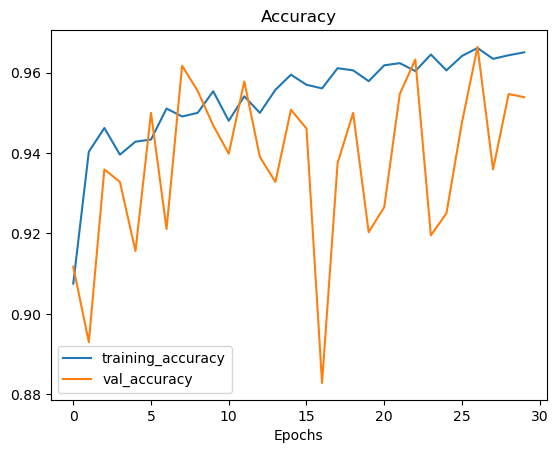

In [46]:
plot_loss_curves(res_ht_history6)

# Confusion Matrix

In [71]:
# Load cnn model with best hyperparameters
best_cnn_model = keras.models.load_model("cnn_ht6.hdf5")
# Predict on test generator dataset
best_cnn_predictions = best_cnn_model.predict(cropped_test_generator)
# Get the index of maximum value from array of prediction probabilities 
best_cnn_predicted_categories = np.argmax(best_cnn_predictions, axis = 1)

4/4 [==============================] - 0s 46ms/step


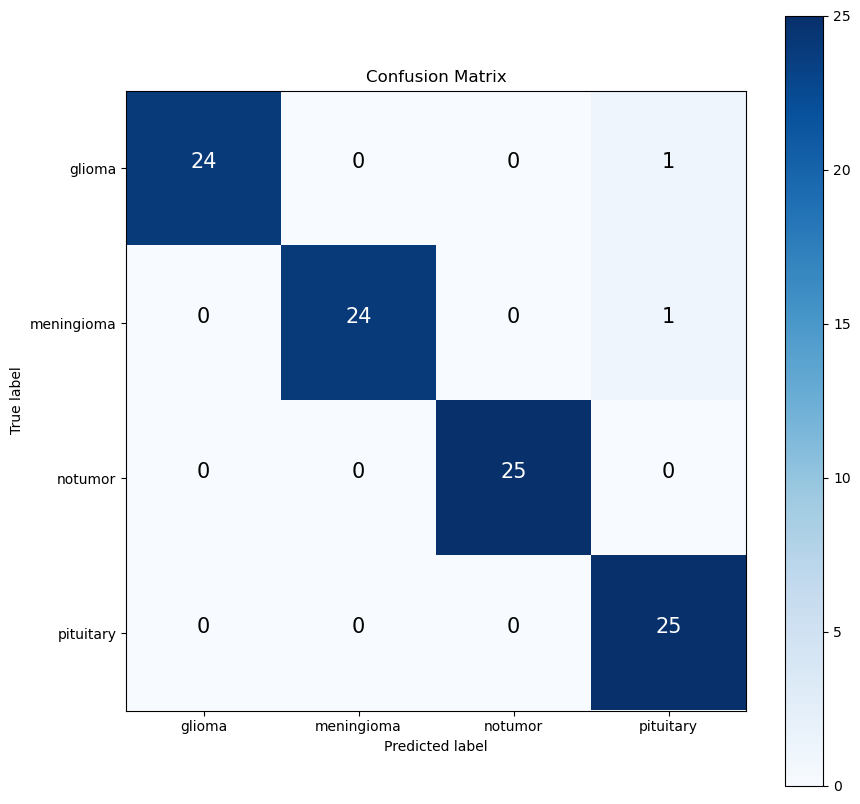

In [79]:
# Create confusion matrix for baseline-CNN model 2 with best hyperparameters
make_confusion_matrix(y_test, best_cnn_predicted_categories, classes = categories)

In [27]:
# Load resnet model with best hyperparameters
best_res_model = keras.models.load_model("res_ht6.hdf5")
# Predict on test generator dataset
best_res_predictions = best_res_model.predict(cropped_test_generator)
# Get the index of maximum value from array of prediction probabilities 
best_res_predicted_categories = np.argmax(best_res_predictions, axis = 1)

4/4 [==============================] - 10s 238ms/step


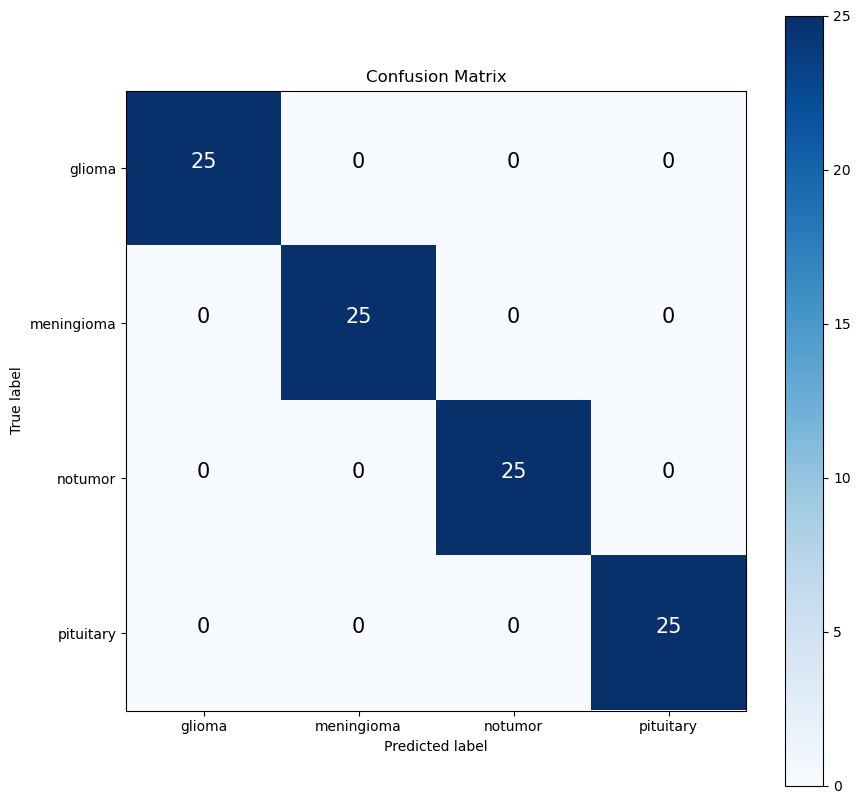

In [28]:
# Create confusion matrix for ResNet50 with best hyperparameters
make_confusion_matrix(y_test, best_res_predicted_categories, classes = categories)